<a href="https://colab.research.google.com/github/rafsantos/tcc_colab_py/blob/main/Convolucao%20PeB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

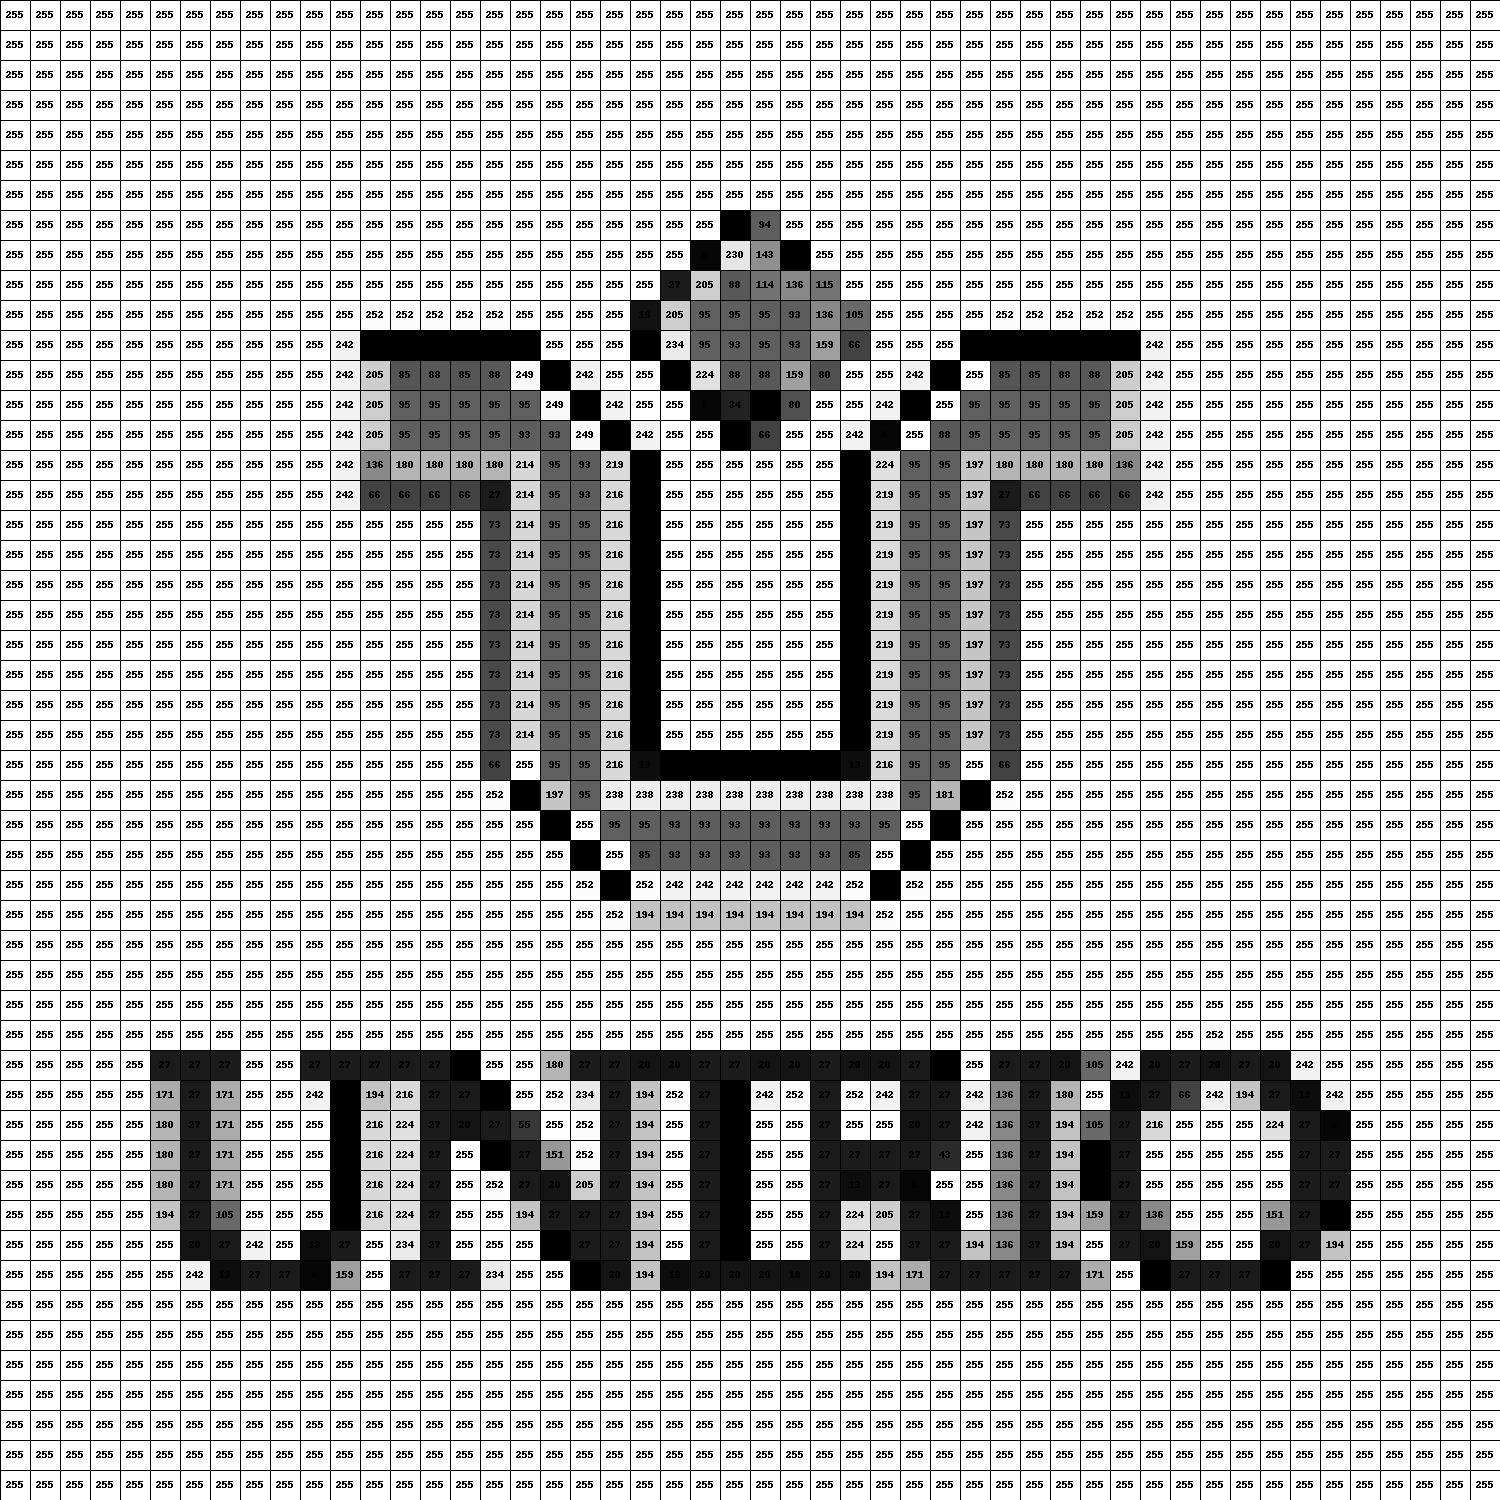

(50, 50, 1)
(52, 52, 1)


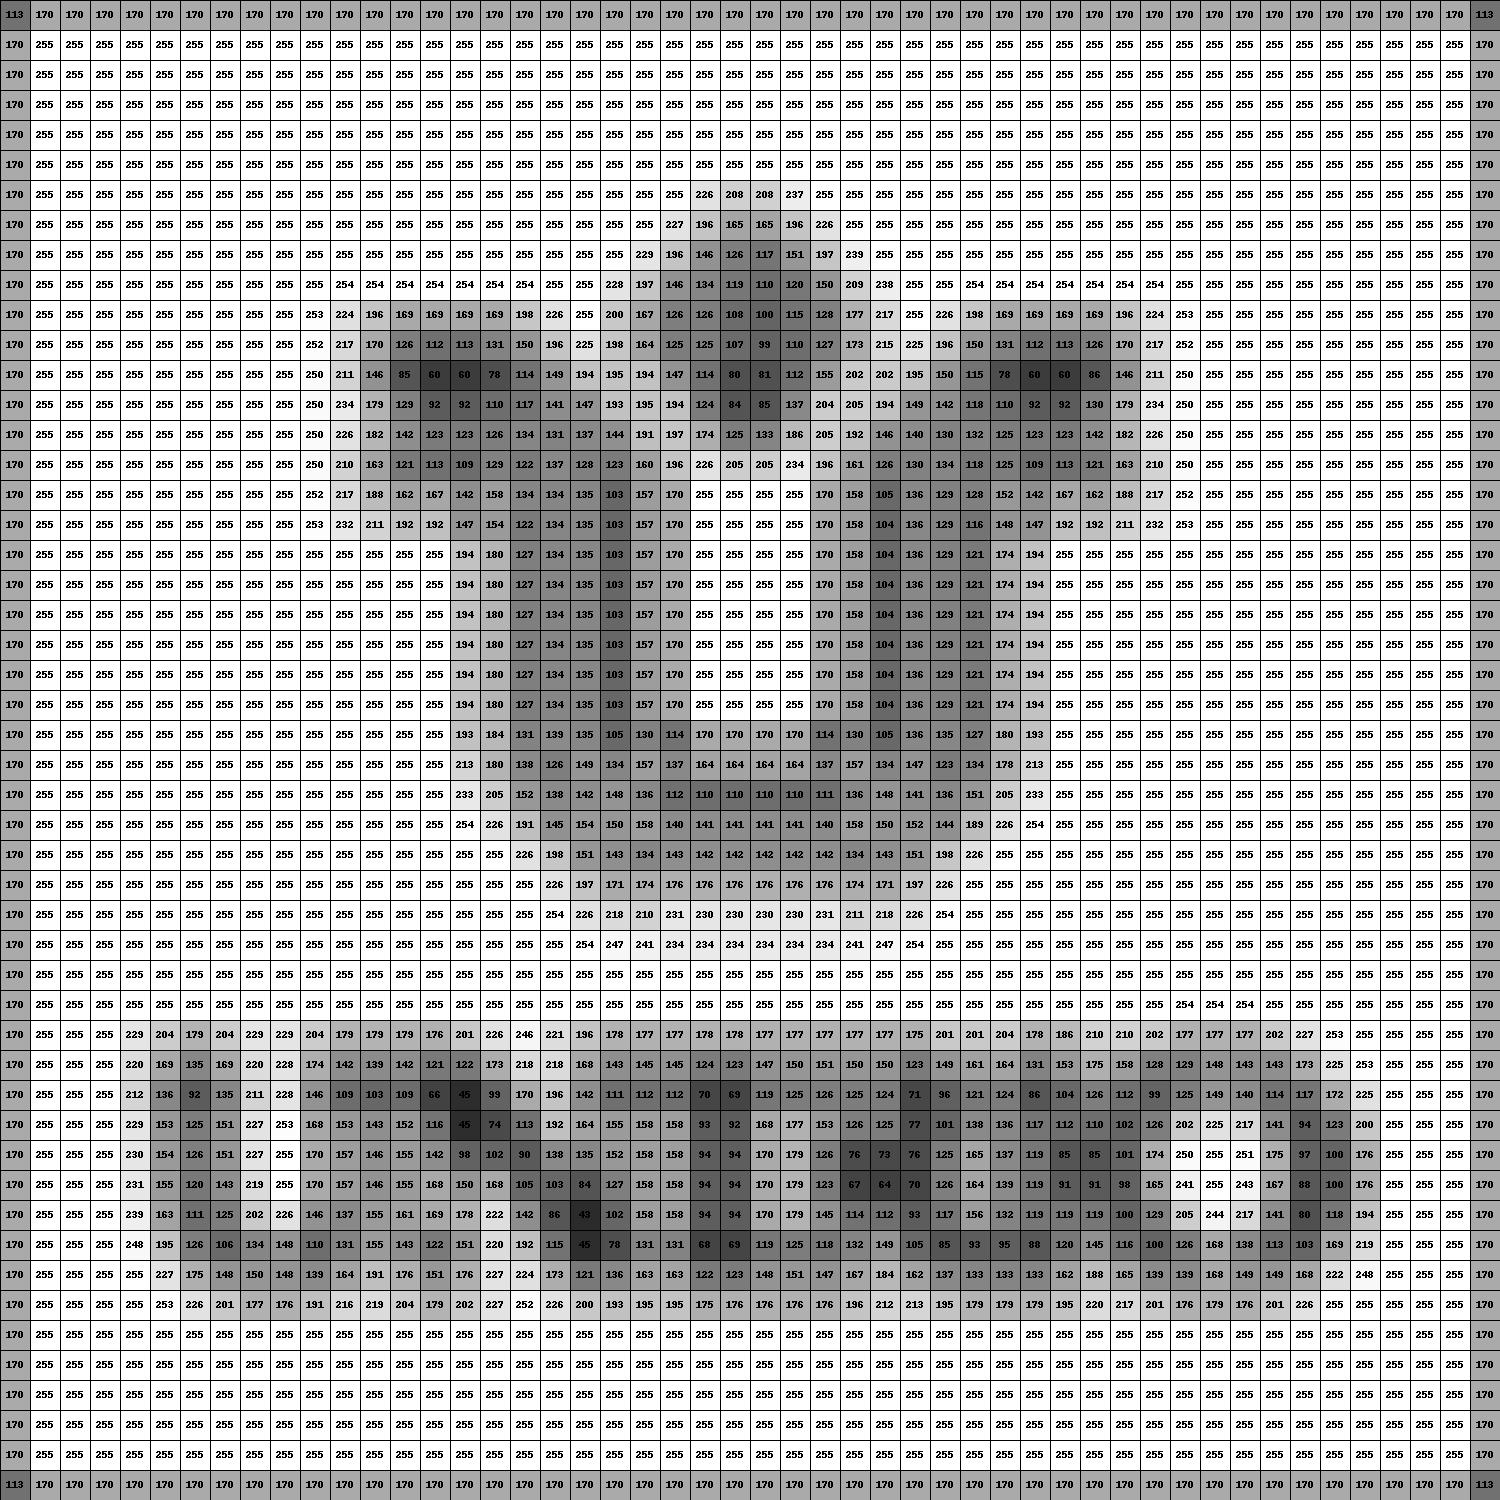

In [19]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import requests

def convolucao(image, filter):

   return image

##### Funcoes #########
def convolve(image, filter, padding = (1, 1)):
    image = np.array(image)
    if(image.ndim == 2):
        image = np.expand_dims(image, axis=-1)
    if(filter.ndim == 2):
        filter = np.repeat(np.expand_dims(filter, axis=-1), image.shape[-1], axis=-1)
    if(filter.shape[-1] == 1):
        filter = np.repeat(filter, image.shape[-1], axis=-1)
    assert image.shape[-1] == filter.shape[-1]
    size_x, size_y = filter.shape[:2]
    width, height = image.shape[:2]

    output_array = np.zeros(((width - size_x + 2*padding[0]) + 1,
                             (height - size_y + 2*padding[1]) + 1,
                             image.shape[-1])) # Convolution Output: [(W−K+2P)/S]+1
    padded_image = np.pad(image, [
        (padding[0], padding[0]),
        (padding[1], padding[1]),
        (0, 0)
    ])
    frames = 0
    for x in range(padded_image.shape[0] - size_x +1):
        for y in range(padded_image.shape[1] - size_y +1):
            # Janela movel do filtro
            window = padded_image[x:x + size_x, y:y + size_y]
            # Soma do produto da janela fo filtro e área da imagem
            output_values = np.sum(filter * window, axis=(0, 1))
            # Guarda resultado no array resultado
            output_array[x, y] = np.asarray(output_values)
    if(output_array.shape[-1] == 1):
      output_array = output_array[:,:,0]
    img = Image.fromarray(output_array.astype('uint8'))
    return img

#Desenha grade em uma imagem com um determinado intervalo
def grade(img,intervalo):
  img = np.array(img)
  img[::intervalo] = 0
  img[:,::intervalo] = 0
  img = Image.fromarray(img.astype('uint8'),'L')
  return img

def leImagemWeb(url):
  im = Image.open(requests.get(url, stream=True).raw).convert('L')
  return im

def ajustaVisual(img,pixH,fator):
  #compacta primeiro
  img = encolhe(img,pixH)
  img = img.resize((img.size[0]*fator,img.size[1]*fator),resample=Image.NEAREST)
  return img

def encolhe(img,pixH):
  img = img.resize((pixH,pixH),resample=Image.NEAREST)
  return img

def escrevePixels(img,fator):
  draw = ImageDraw.Draw(img)
  font = ImageFont.load_default()

  img_arr = np.array(img)

  for y in range(0,img_arr.shape[1],fator):
    for x in range(0,img_arr.shape[0],fator):
      txt = str(np.transpose(img_arr)[x,y])
      txtbox = font.getbbox(txt)
      #Alinhando o texto no centro do quadrado
      draw.text((x + fator/2 - txtbox[2]/2, y + fator/2 - txtbox[3]/2 ), txt, anchor='mm')
  return img



###############################################
fator = 30
pixHoriz = 50

filtro = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
    ], dtype=np.float32)/9.0

# Vou obter uma imagem da web
#url = ("https://i.ibb.co/D81PNZz/image.png")
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSzFVq9sCTckUxKmHj7YTLlKQH6nkicNS_UQ9XUdvdeLg&s"
#url = 'https://live.staticflickr.com/4830/44200095760_4d993be1cb_b.jpg'

img = leImagemWeb(url)

#Ajustando exibicao da imagem de entrada
img_in = ajustaVisual(img,pixHoriz,fator)
img_in = escrevePixels(img_in,fator)
img_in = grade(img_in,fator)
display(img_in)

#processand a imagem
img = encolhe(img,pixHoriz)
img = convolve(img,filtro)
img = ajustaVisual(img,pixHoriz,fator)

#escrevendo os valores de cada pixel
img = escrevePixels(img,fator)

#Desenha grade
img = grade(img,fator)
display(img)

###### #############
##### ATE AQUI OK
#Fazendo convolucao


#img_conv = convolucao(im_out_gd,filtro)
#display(img)
#display(im_out_gd)
#img_conv2 = convolve(im_out_gd,filtro)
#display(img_conv2)
